In [1]:
from tomoSegmentPipeline.utils.common import read_array, write_array
from tomoSegmentPipeline.utils import setup
from cryoS2Sdrop.dataloader import singleCET_dataset

import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from torch.utils.data import Dataset, DataLoader

PARENT_PATH = setup.PARENT_PATH
ISONET_PATH = os.path.join(PARENT_PATH, 'data/isoNet/')

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

# Make grid method

I want to create a set of overlapping intervals of size subtomo_length that cover the entire tomogram and that dont overlap too much to reduce the number of intervals that I need to cover the tomogram.

## Pilot in 1D

In [28]:
L = 928
s = 64

n_intervals = L/s
n_intervals # the decimal part means we have a surplus

14.5

In [29]:
surplus = L%s
surplus

32

So what should happen now is that this surplus should be distributed across L such that it is completely covered with little overlap.

To achieve this, I can create one more interval across L, however I still need to fulfill some constraints:
1. All of the intervals should have the same size s. 
2. The amount of overlapping might vary, but it needs to be small

In [30]:
pcenters, step = np.linspace(s//2, L-s//2, int(np.ceil(n_intervals)), dtype=int, retstep=True)
intervals, step

(array([ 4, 11, 19, 27, 34, 42, 50, 57, 65, 73, 80, 88, 96]),
 61.714285714285715)

In [31]:
startpoints, endpoints = pcenters-s//2, pcenters+s//2
max(endpoints[:-1]-startpoints[1::])/s # overlap

0.046875

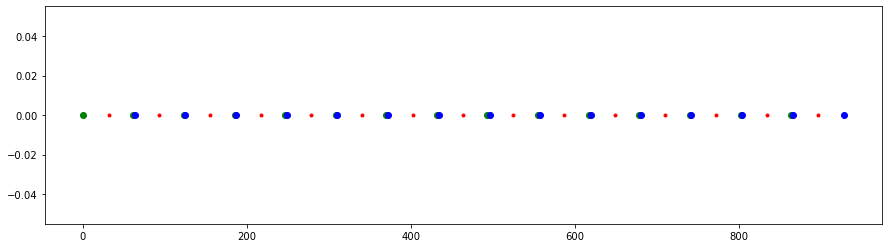

In [32]:
y0 = np.zeros_like(pcenters)

plt.figure(figsize=(15, 4))
plt.scatter(x=pcenters, y=y0, c='r', marker='.')
plt.scatter(x=startpoints, y=y0, c='g')
plt.scatter(x=endpoints, y=y0, c='b')

## 3D tomogram

In [18]:
cet_path = os.path.join(PARENT_PATH, 'data/raw_cryo-ET/tomo02.mrc') 
tomo_data = read_array(cet_path)

subtomo_length = 128

tomo_data.shape

(464, 928, 928)

In [19]:
zyx = tomo_data.shape # tomogram dimensions
max_length = max(zyx)
dist_center = subtomo_length//2 # size from center

n_centers = int(np.ceil(max_length/subtomo_length))
n_centers

8

In [23]:
pcenters = []
for i, coord in enumerate(zyx):

    n_centers = int(np.ceil(coord/subtomo_length))
    pcenter = np.linspace(dist_center, coord-dist_center, n_centers, dtype=int)
    
    startpoints, endpoints = pcenter-dist_center, pcenter+dist_center
    overlap_ratio = max(endpoints[:-1]-startpoints[1::])/dist_center # overlap

    pcenters.append(pcenter)
    print(overlap_ratio)
    
    if overlap_ratio<0:
        raise ValueError('The tomogram is not fully covered in dimension %i.' %i)
        
    if overlap_ratio>0.5:
        raise ValueError('There is too much overlap between patches in dimension %i.' %i)

z, y, x = zyx

0.25
0.21875
0.21875


In [22]:
overlap_ratio

0.21875

In [13]:
zs, ys, xs = np.meshgrid(*pcenters, indexing='ij')
grid = list(zip(zs.flatten(), ys.flatten(), xs.flatten()))
len(grid)

1800

# Implementation on the Dataset

In [2]:
# cet_path = os.path.join(PARENT_PATH, 'data/raw_cryo-ET/tomo02.mrc') 
cet_path = os.path.join(PARENT_PATH, 'data/S2SDenoising/dummy_tomograms/tomo02_dummy.mrc')

p=0.3
batch_size = 8
num_gpus = 2
subtomo_length = 128

my_dataset = singleCET_dataset(cet_path, subtomo_length, p=p, volumetric_scale_factor=8)
print('Size of dataset: %i, Steps per epoch: %i' %(len(my_dataset), len(my_dataset)/(batch_size*num_gpus)))

Size of dataset: 32, Steps per epoch: 2


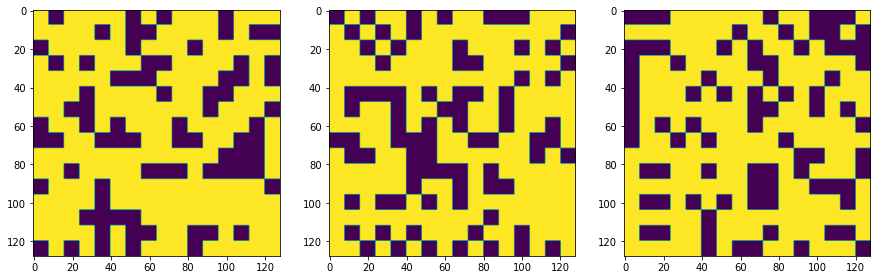

In [3]:
mask = my_dataset.create_Vmask()[0]

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 8))

aux_idx = subtomo_length//2
ax0.imshow(mask[aux_idx])
ax1.imshow(mask[:,aux_idx, :])
ax2.imshow(mask[:, :,aux_idx])

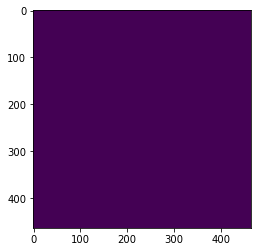

In [4]:
# grid sanity check
tomo_data = my_dataset.data

dummy_tomo = torch.zeros_like(torch.tensor(tomo_data))

for idx in range(len(my_dataset)):
    
    z0, y0, x0 = my_dataset.grid[idx]
    zmin, zmax = z0-subtomo_length//2, z0+subtomo_length//2
    ymin, ymax = y0-subtomo_length//2, y0+subtomo_length//2
    xmin, xmax = x0-subtomo_length//2, x0+subtomo_length//2

    dummy_tomo[zmin:zmax, ymin:ymax, xmin:xmax] = 1
    
plt.imshow(dummy_tomo[-1])

In [5]:
# fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(18, 8))
# zidx = my_dataset.tomo_shape[0]//2
# ax0.imshow(my_dataset.data[zidx])
# ax1.imshow(my_dataset.bernoulli_mask[0][zidx])

In [6]:
# check last set of dimensions across Z
tomo_data.shape, dummy_tomo[zmin:zmax].shape, zmin, zmax

(torch.Size([232, 464, 464]), torch.Size([128, 464, 464]), 104, 232)

In [7]:
ymax, xmax

(464, 464)

In [8]:
idx = 0
subtomo, target, mask = my_dataset[idx]
subtomo.shape

torch.Size([1, 128, 128, 128])

(array([   9098.,   22602.,   53930.,   95626.,  128262., 1605921.,
          96361.,   53292.,   22817.,    9243.]),
 array([-2.618816 , -2.0960007, -1.5731853, -1.05037  , -0.5275547,
        -0.0047394,  0.5180759,  1.0408912,  1.5637065,  2.0865219,
         2.609337 ], dtype=float32),
 <BarContainer object of 10 artists>)

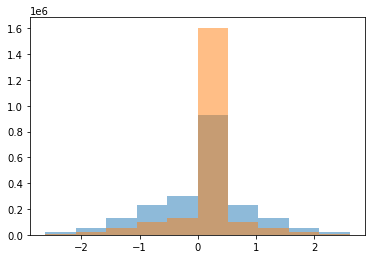

In [9]:
plt.hist(subtomo.squeeze().numpy().flatten(), alpha=0.5)
plt.hist(target.squeeze().numpy().flatten(), alpha=0.5)

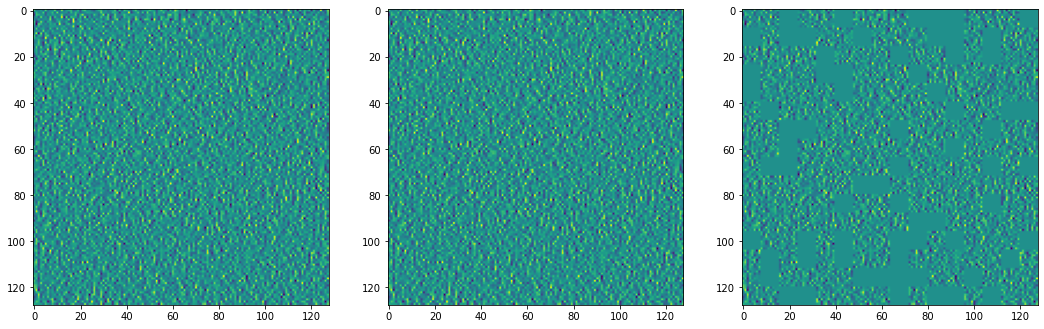

In [11]:
z0, y0, x0 = my_dataset.grid[idx]
zmin, zmax = z0-subtomo_length//2, z0+subtomo_length//2
ymin, ymax = y0-subtomo_length//2, y0+subtomo_length//2
xmin, xmax = x0-subtomo_length//2, x0+subtomo_length//2

aux_patch = tomo_data[zmin:zmax, ymin:ymax, xmin:xmax]

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(18, 8))
zidx = 43
ax0.imshow((target+subtomo)[0][zidx])
ax1.imshow(aux_patch[zidx])
ax2.imshow(subtomo[0][zidx])

In [12]:
(mask==0).sum()/torch.prod(torch.tensor(subtomo.shape))

tensor(0.2954)

In [13]:
((target + subtomo).squeeze() - aux_patch).abs().max()

tensor(0.)

(array([ 31087.,  75972., 181842., 325260., 432874., 434427., 325415.,
        181692.,  76837.,  31746.]),
 array([-2.618816 , -2.0960007, -1.5731853, -1.05037  , -0.5275547,
        -0.0047394,  0.5180759,  1.0408912,  1.5637065,  2.0865219,
         2.609337 ], dtype=float32),
 <BarContainer object of 10 artists>)

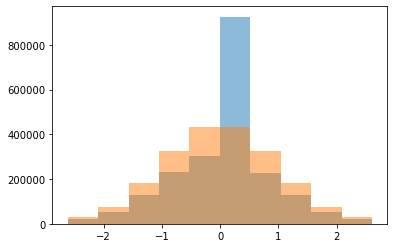

In [14]:
plt.hist(subtomo.squeeze().numpy().flatten(), alpha=0.5)
plt.hist((target+subtomo).squeeze().numpy().flatten(), alpha=0.5)

(array([ 957361., 2013888., 4447247., 7560822., 9885007., 9926292.,
        7632401., 4506747., 2049110.,  969797.]),
 array([-2.618816 , -2.0960007, -1.5731853, -1.05037  , -0.5275547,
        -0.0047394,  0.5180759,  1.0408912,  1.5637065,  2.0865219,
         2.609337 ], dtype=float32),
 <BarContainer object of 10 artists>)

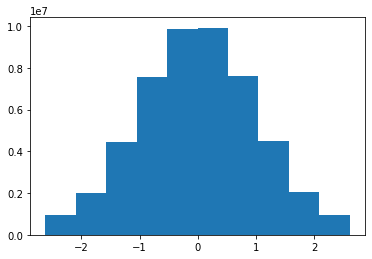

In [15]:
plt.hist(my_dataset.data.flatten().numpy())